<a href="https://colab.research.google.com/github/YvesAugusto/Object-Localization/blob/main/object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from skimage.transform import resize
from matplotlib.patches import Rectangle

In [2]:
def base_model(img_dim):
  vgg = VGG16(
    input_shape=[img_dim, img_dim, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001))
  return model

In [6]:
IMG_SIZE = 200
new_height = 200
new_width = 200
from imageio import imread
img = imread('./drive/My Drive/bar_simpson.png')

back_ground = []
ra_fild12 = np.array(image.load_img('./drive/My Drive/ra_fild.png'))
ra_fild12 = resize(
            ra_fild12,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(ra_fild12)
lhz_dun = np.array(image.load_img('./drive/My Drive/lhz_dun.png'))
lhz_dun = resize(
            lhz_dun,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(lhz_dun)
orc_dun = np.array(image.load_img('./drive/My Drive/orc_dun.jpg'))
orc_dun = resize(
            orc_dun,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(orc_dun)
rachel_san = np.array(image.load_img('./drive/My Drive/rachel_san.jpeg'))
rachel_san = resize(
            rachel_san,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(rachel_san)
airplane = np.array(image.load_img('./drive/My Drive/airplane.jpeg'))
airplane = resize(
            airplane,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(airplane)

In [4]:
img = np.array(img)
height, width, _ = img.shape

def train_generator(batch_size=64):
  while True:
    
    for _ in range(50):
      x_vec = np.arange(len(back_ground))
      X=[]
      for i in range(batch_size):
        np.random.shuffle(x_vec)
        index = x_vec[0]
        X.append(np.array(back_ground[index]))
      X = np.array(X)
      # X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3))
      Y = np.zeros((batch_size, 4))
      for i in range(batch_size):
        scale_vector = np.arange(0.125, 0.275, 0.05)
        np.random.shuffle(scale_vector)
        scale = scale_vector[0]
        new_height = int(height * scale)
        new_width = int(width * scale)
        obj = resize(
            img,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
        row0 = np.random.randint(IMG_SIZE - new_height)
        col0 = np.random.randint(IMG_SIZE - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width
        mask = (obj[:,:,3] == 0)
        windows = X[i,row0:row1,col0:col1,:]
        windows = np.expand_dims(mask, -1) * windows
        windows += obj[:,:,:3]
        X[i,row0:row1,col0:col1,:] = windows
        
        Y[i,0] = row0/IMG_SIZE
        Y[i,1] = col0/IMG_SIZE
        Y[i,2] = (row1 - row0)/IMG_SIZE
        Y[i,3] = (col1 - col0)/IMG_SIZE
        
      
      yield X / 255., Y

In [7]:
model = base_model(IMG_SIZE)
model.fit_generator(
    train_generator(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 52s 1s/step - loss: 0.5942
Epoch 2/5
50/50 [==============================] - 53s 1s/step - loss: 0.5516
Epoch 3/5
50/50 [==============================] - 53s 1s/step - loss: 0.5493
Epoch 4/5
50/50 [==============================] - 53s 1s/step - loss: 0.5476
Epoch 5/5
50/50 [==============================] - 52s 1s/step - loss: 0.5490


In [13]:
def predict():
  scale_vector = np.arange(0.125, 0.275, 0.05)
  np.random.shuffle(scale_vector)
  scale = scale_vector[0]
  new_height = int(height * scale)
  new_width = int(width * scale)
  obj = resize(
      img,
      (new_height, new_width),
      preserve_range=True).astype(np.uint8) # keep it from 0..255
  obj = np.array(obj)
  print(obj.shape)
  # Generate a random image
  x_vec = np.arange(len(back_ground))
  np.random.shuffle(x_vec)
  index = x_vec[0]
  x = back_ground[index]
  print(x.shape)
  # x = np.zeros((IMG_SIZE, IMG_SIZE, 3))
  row0 = np.random.randint(IMG_SIZE - new_height)
  col0 = np.random.randint(IMG_SIZE - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width
  
  mask = (obj[:,:,3] == 0)
  windows = x[row0:row1,col0:col1,:]
  windows = np.expand_dims(mask, -1) * windows
  windows += obj[:,:,:3]
  x[row0:row1,col0:col1,:] = windows
  print("true:", row0, col0, row1, col1)
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Draw the box
  row0 = int(p[0]*IMG_SIZE)
  col0 = int(p[1]*IMG_SIZE)
  row1 = int(row0 + p[2]*IMG_SIZE)
  col1 = int(col0 + p[3]*IMG_SIZE)
  print("pred:", row0, col0, row1, col1)
  
  
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
      p[3]*IMG_SIZE, p[2]*IMG_SIZE,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

(44, 44, 4)
(200, 200, 3)
true: 71 33 115 77
pred: 72 34 116 77


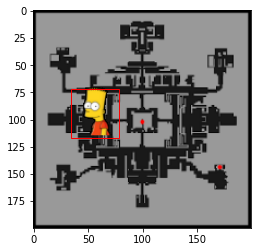

In [15]:
predict()